In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
import torch
from libs.curve_rays import CurveModel
from libs.other_helpers import unit_vector, random_on_unit_sphere
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
near = 0.
far = 6.
N_samples = 100
N_rays = 1
steps = 100

In [4]:
def dot(a, b):
    return torch.einsum('...i,...i', a, b).unsqueeze(-1)

In [5]:
class Force:
    def __init__(self, r0, space):
        self.r0 = r0
        self.f = self.f_schwarzschild if space == 'schwarzschild' else self.f_straight

    def __call__(self, r, v):
        return self.f(r, v)

    def f_schwarzschild(self, r, v):
        r = r - self.r0
        c = torch.cross(r, v)
        h2 = dot(c, c)
        return -1.5 * h2 * r / torch.pow(dot(r, r), 2.5)

    def f_straight(self, r, v):
        return 0

In [6]:
def verlet(r, v, f, dt=0.01):
    v05 = v + 0.5 * f(r, v) * dt
    r1 = r + v05 * dt
    v1 = v05 + 0.5 * f(r1, v) * dt / 2
    return r1, v1

In [7]:
def predict_ray_network(rays_o, rays_d):
    t_vals = torch.linspace(0., 1., steps=N_samples)
    z_vals = near * (1. - t_vals) + far * t_vals
    z_vals = z_vals.expand([N_rays, N_samples])
    
    input_batch = torch.cat((rays_o, rays_d), dim=-1).unsqueeze(1)
    input_batch = input_batch.expand(N_rays, N_samples, 6)
    input_batch = torch.cat((input_batch, z_vals.unsqueeze(-1)), dim=-1)
    o = model(input_batch)
    o = o.detach().cpu().numpy()
    return o

In [8]:
def predict_ray_evol(rays_o, rays_d):
    pos = [rays_o.cpu().numpy()]
    for it in range(steps):
        rays_o, rays_d = verlet(rays_o, rays_d, f)
        pos.append(rays_o.cpu().numpy())
        
    return np.array(pos)

In [9]:
def predict(rays_o, rays_d):
    rays_d = unit_vector(rays_d)
    
    o_n = predict_ray_network(rays_o, rays_d)
    o_e = predict_ray_evol(rays_o, rays_d)
    return {'net': o_n, 'ev': o_e}

In [10]:
r0 = torch.tensor((0, 0, 0))
f = Force(r0, 'schwarzschild')

In [11]:
ckpt_path = '../logs/spheres_condensation_curved/340000.tar'

In [12]:
model = CurveModel()
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['curver'])
model.eval()

CurveModel(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [13]:
rays_o = random_on_unit_sphere((N_rays, 3)) * 4
rays_d = -1 * torch.rand((N_rays, 3)) + 1 # This is distributed -1 to 1
rays_d = unit_vector(rays_d)

In [14]:
rays_o = torch.tensor([[ 0.9117,  2.6744, -2.8313]])
rays_d = torch.tensor([[-0.2023, -0.7369,  0.6516]])

In [15]:
o = predict(rays_o, rays_d)

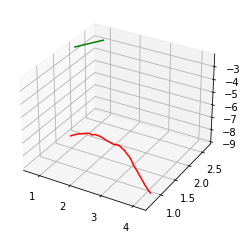

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(o['net'][0, :, 0], o['net'][0, :, 1], o['net'][0,:, 2], color='red')
ax.plot(o['ev'][:, 0, 0], o['ev'][:, 0, 1], o['ev'][:, 0, 2], color='green')
plt.show()

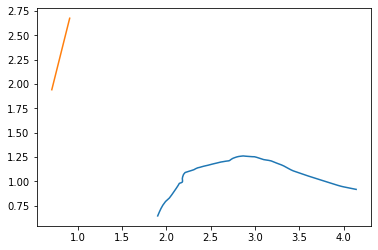

In [17]:
plt.plot(o['net'][0, :, 0], o['net'][0, :, 1])
plt.plot(o['ev'][:, 0, 0], o['ev'][:, 0, 1])

In [18]:
rays_o, rays_d

(tensor([[ 0.9117,  2.6744, -2.8313]]), tensor([[-0.2023, -0.7369,  0.6516]]))

In [19]:
b = torch.tensor([[ -0.9117,  2.6744, -2.8313, -0.2023, -0.7369,  0.6516,  0.]])
model(b)

tensor([[ 1.8880,  0.6257, -5.6556]], grad_fn=<AddmmBackward>)

In [42]:
rays_o = torch.tensor([[ 0.,  2.1744, -2.],
                       [ 0.,  2.2744, -2.],
                       [ 0.,  2.3744, -2.],
                       [ 0.,  2.4744, -2.],
                       [ 0.,  2.5744, -2.],
                       [ 0.,  2.6744, -2.],
                       [ 0.,  2.7744, -2.],
                       [ 0.,  2.8744, -2.]])

rays_d = torch.tensor([[ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516],
                       [ -0., 0.7369,  0.6516]])

In [49]:
rays_d = unit_vector(rays_d)

In [50]:
t_vals = torch.linspace(0., 1., steps=N_samples)
z_vals = near * (1. - t_vals) + far * t_vals
z_vals = z_vals.expand([8, N_samples])

input_batch = torch.cat((rays_o, rays_d), dim=-1).unsqueeze(1)
input_batch = input_batch.expand(8, N_samples, 6)
input_batch = torch.cat((input_batch, z_vals.unsqueeze(-1)), dim=-1)

In [51]:
input_batch.shape

torch.Size([8, 100, 7])

In [52]:
o = model(input_batch)
o = o.detach().cpu().numpy()

In [53]:
o.shape

(8, 100, 3)

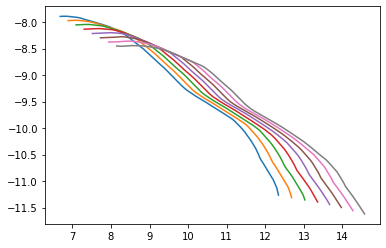

In [54]:
for o_i in o:
    plt.plot(o_i[:, 1], o_i[:,2])

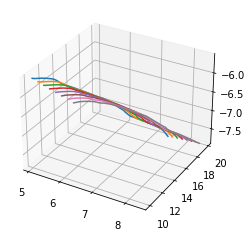

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for o_i in o:
    plt.plot(o_i[:, 0], o_i[:, 1], o_i[:, 2])